# Transmission Line Properties and Manipulations
In this tutorial, `scikit-rf` is used to work with some classical transmissione line situations
. 

First, let's make the necessary Python import statements:

In [183]:
%matplotlib inline
import skrf as rf 
from pylab import * 

In [184]:
rf.stylely()

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\style\core.py:112: UserWarning: Style includes a parameter, 'interactive', that is not related to style.  Ignoring
  _apply_style(rc)


# Loaded transmission line
Let's consider a lossy coaxial cable of characteristic impedance $Z_0=75 \Omega$ of length $L=10 m$ and attenuation 0.02 Np/m. The cable is loaded with a $Z_L=150 \Omega$ impedance. In `scikit-rf`, the line length is defined from the load, ie $z=0$ at the load and $z=L$ at the input of the transmission line.
![](Impedance_matching_1.svg) 

The constants are defined:

In [185]:
freq = rf.Frequency(250, npoints=1, unit='MHz')
Z_0 = 75  # Ohm
Z_L = 150  # Ohm
L = 12  # m
lambd = rf.c/freq.f/sqrt(4)  # coaxial insulator eps_r=4
alpha = 0.01904  # Np/m
beta = 2*pi/lambd
gamma = alpha + 1j*beta
print('Transmission line propagation constant: gamma = ', gamma, 'rad/m')

Transmission line propagation constant: gamma =  [0.01904+10.47922511j] rad/m


Let's create the transmission line `media` object: 

In [186]:
# if not passing the gamma parameter, it would assume that gamma = alpha + j*beta = 0 + j*1
coax_line = rf.media.DefinedGammaZ0(frequency=freq, Z0=Z_0, gamma=gamma)

### Input impedance and reflection coefficient

`scikit-rf` brings few convenient functions to deal with transmission lines. They are detailled in the [transmission line functions](https://scikit-rf.readthedocs.io/en/latest/api/tlineFunctions.html) documentation pages. For example, the input impedance $Z_{in}$ can be calculated from:

In [187]:
Z_in = rf.zl_2_zin(Z_0, Z_L, coax_line.electrical_length(L))
print('Input impedance Z_in = ', Z_in, ' Ohm')

Input impedance Z_in =  [113.96360293-8.71652627j]  Ohm


and the reflection coefficient at the line input $\Gamma_{in}$ from:

In [188]:
Gamma_in = rf.zl_2_Gamma_in(Z_0, Z_L, coax_line.electrical_length(L))
print('Reflection coefficient |Gamma_in| = ', abs(Gamma_in))

Reflection coefficient |Gamma_in| =  [0.21106856]


Or in Standing Wave Ratio seen at the line input:

In [189]:
print('SWR = ', rf.Gamma0_2_swr(Gamma_in))

SWR =  [1.53507452]


Another possibility to obtain the input impedance is by building the circuit by [cascading](https://scikit-rf.readthedocs.io/en/latest/tutorials/Networks.html#Cascading-and-De-embedding) its various Network elements: [transmission line](https://scikit-rf.readthedocs.io/en/latest/api/media/generated/skrf.media.media.Media.line.html) of length $L$, a [resistor](https://scikit-rf.readthedocs.io/en/latest/api/media/generated/skrf.media.media.Media.resistor.html), then a [short](https://scikit-rf.readthedocs.io/en/latest/api/media/generated/skrf.media.media.Media.short.html). This results in a one-port network, which $Z$-parameter is then the input impedance: 

In [190]:
ntw = coax_line.line(L, unit='m') ** coax_line.resistor(Z_L) ** coax_line.short()
ntw.z

array([[[113.96360293-8.71652627j]]])

The previous Network can also be built with convenience functions [load](https://scikit-rf.readthedocs.io/en/latest/api/media/generated/skrf.media.media.Media.load.html) or [delay_load](https://scikit-rf.readthedocs.io/en/latest/api/media/generated/skrf.media.media.Media.delay_load.html):

In [191]:
ntw = coax_line.line(L, unit='m') ** coax_line.load(rf.zl_2_Gamma0(Z_0, Z_L))
ntw.z

array([[[113.96360293-8.71652627j]]])

In [192]:
ntw = coax_line.delay_load(rf.zl_2_Gamma0(Z_0, Z_L), L, unit='m')
ntw.z

array([[[113.96360293-8.71652627j]]])

### Voltages and Currents

Now assume that the previous circuit is excited by a source delivering a voltage $V=80 V$ associated to a source impedance $Z_s=100\Omega$ :
![](Impedance_matching_with_source.svg)

In [193]:
Z_s = 100  # Ohm
V_s = 80  # V

At the input of the transmission line, the voltage is a voltage divider circuit:
$$
V_{in} = V_s  \frac{Z_{in}}{Z_s + Z_{in}}
$$

In [194]:
V_in = V_s * Z_in / (Z_s + Z_in)
print('Voltage at transmission line input : V_in = ', V_in, ' V')

Voltage at transmission line input : V_in =  [42.67241261-1.52066469j]  V


and the current at the input of the transmission line is:
$$
I_{in} = \frac{V_s}{Z_s + Z_{in}}
$$

In [195]:
I_in = V_s / (Z_s + Z_in)
print('Current at transmission line input : I_in = ', I_in, ' A')

Current at transmission line input : I_in =  [0.37327587+0.01520665j]  A


which represent a power of 
$$
P_{in} = \frac{1}{2} \Re \left[V_{in} I_{in}^* \right]
$$

In [196]:
P_in = 1/2 * real(V_in * conj(I_in))
print('Input Power : P_in = ', P_in, 'W')

Input Power : P_in =  [7.95272895] W


The reflected power is:
$$
P_r = |\Gamma_{in}|^2 P_{in}
$$

In [197]:
P_r = abs(Gamma_in)**2 * P_in
print('Reflected power : P_r = ', P_r, 'W')

Reflected power : P_r =  [0.35429356] W


The voltage and current at the load can be deduced from the ABCD parameters of the line of length $L$ :

In [198]:
V_out, I_out = rf.voltage_current_propagation(V_in, I_in, coax_line.z0, 
                                              theta=coax_line.electrical_length(L))
print('Voltage at load: V_out = ', V_out, 'V')
print('Current at load: I_out = ', I_out, 'A')

Voltage at load: V_out =  [37.32976691-3.45816874j] V
Current at load: I_out =  [0.24886511-0.02305446j] A


In [199]:
P_out = 1/2 * real(V_out * conj(I_out))
print('Power delivered to the load : P_out = ', P_out, ' W')

Power delivered to the load : P_out =  [4.68490143]  W


Voltage and current be plotted against the transmission line length (pay attention to the sign of $\theta$ in the voltage and current propagation: as we go from source ($z=L$) to the load ($z=0$), $\theta$ goes in the opposite direction and should be inversed)

In [200]:
Ls = linspace(0, -L, num=101)
f = linspace(1, 250, num=201)
gamma = alpha + 1j*ones_like(f)

# creating (nb_gamma, nb_f) array
thetas = gamma[:, None]*Ls 

v1 = V_in*ones_like(Ls)
i1 = I_in*ones_like(Ls)

v2, i2 = rf.voltage_current_propagation(v1, i1, Z_0, theta=thetas)

Text(0.5, 1.0, 'Voltage')

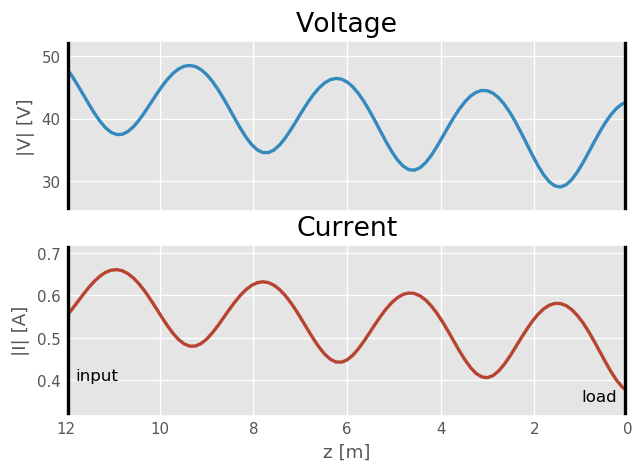

In [210]:
fig, (ax_V, ax_I) = plt.subplots(2, 1, sharex=True)
ax_V.plot(-Ls, abs(v2[0,:]), lw=2)
ax_I.plot(-Ls, abs(i2[0,:]), lw=2, c='C1')
ax_I.set_xlabel('z [m]')
ax_V.set_ylabel('|V| [V]')
ax_I.set_ylabel('|I| [A]')
ax_V.invert_xaxis()

ax_V.axvline(0, c='k', lw=5)
ax_I.axvline(0, c='k', lw=5)
ax_I.text(L-0.2, 0.4, 'input')
ax_V.axvline(L, c='k', lw=5)
ax_I.axvline(L, c='k', lw=5)
ax_I.text(1, 0.35, 'load')
ax_I.set_title('Current')
ax_V.set_title('Voltage')

# Determination of the propagation constant from input impedance
Let's assume the input impedance of a short‐circuited lossy transmission line of length d=1.5 m and a characteristic impedance of $Z_0=$100 Ohm has been measured to $Z_{in}=40 - 280j \Omega$. 

![](Impedance_matching_2.svg)

The transmission line propagation constant $\gamma$ is unknown and researched. Let see how to deduce its value  using `scikit-rf`:

In [179]:
# input data
z_in = 20 - 140j
z_0 = 75
d = 1.5
Gamma_load = -1 # short

Since we know the input impedance, we can deduce the reflection coefficient at the input of the transmission line. Since there is a direction relationship between the reflection coefficient at the load and at the input of the line:
$$
\Gamma_{in} = \Gamma_L e^{- 2 \gamma d}
$$
we can deduce the propagation constant value $\gamma$ as:
$$
\gamma = -\frac{1}{2d} \ln \left( \frac{\Gamma_{in}}{\Gamma_l} \right)
$$
This is what the convenience function `reflection_coefficient_2_propagation_constant` is doing:

In [180]:
# reflection coefficient at input
Gamma_in = rf.zl_2_Gamma0(z_0, z_in)
# line propagation constant
gamma = rf.reflection_coefficient_2_propagation_constant(Gamma_in, Gamma_load, d)
print('Line propagation constant, gamma =', gamma, 'rad/m')

Line propagation constant, gamma = [0.03920416+1.37070847j] rad/m


One can check the consistency of the result by making the reverse calculation: the input impedance at a distance $d$ from the load $Z_l$:

In [181]:
rf.zl_2_zin(z_0, zl=0, theta=gamma * d)

array([20.-140.j])

Which was indeed the value given as input of the example.

Now that the line propagation constant has been determined, one can replace the short by a load resistance:

In [182]:
rf.zl_2_zin(z_0, zl=50+50j, theta=gamma * d)

array([37.90976384-20.46175538j])

## another example


In [368]:
L = 7.5e-2
f = 1e9
z0 = 50
Gamma_L=0.2

gamma = 1j*2*pi*f/rf.c

In [369]:
zin = rf.Gamma0_2_zin(z0, Gamma_L, gamma*L)

In [370]:
pin = 4.328e-3
sqrt(2*30*pin)#*(1 - abs(rf.Gamma0_2_Gamma_in(Gamma_L, gamma*L))**2)

0.5095880689341147

In [371]:
vin = 1 * zin / (zin + 30)
iin = vin / (zin + 30)
print(vin, iin)

[0.52631606+0.00022592j] [0.00831025-3.96358707e-07j]


In [372]:
Gamma_in = (rf.Gamma0_2_Gamma_in(Gamma_L, gamma*L))
print(Gamma_in)  # OK
vin = 1 * zin / (zin + 30) 
iin = vin / zin  # OK
print(vin, iin)  # OK

[-0.19999953+0.00043498j]
[0.52631606+0.00022592j] [0.01578946-7.53073772e-06j]


In [375]:
# voltage and current at load
vl,il = rf.voltage_current_propagation(vin, iin, z0=50, theta=gamma*d)

In [376]:
1/2*real(vin*conj(iin))  # OK

array([0.00415512])

In [490]:
freq = rf.Frequency(1, unit='GHz', npoints=1)
line50 = rf.media.DefinedGammaZ0(frequency=freq, gamma=1j*beta, z0=50)
line25 = rf.media.DefinedGammaZ0(frequency=freq, gamma=1j*beta, z0=25)

port = rf.Circuit.Port(frequency=freq, z0=30, name='port')
line1 = line50.line(7.5e-2, unit='m', name='line1')
#line2 = line25.line(5e-2, unit='m', name='line2')
load = line50.resistor(75, name='load', z0=75)
gnd = rf.Circuit.Ground(frequency=freq, z0=75, name='gnd')

cnx = [
    [(port,0), (line1, 0)],
    [(line1, 1), (load, 0)],
    [(load, 1), (gnd,0)],
]
circuit = rf.Circuit(cnx)


$$
a_0 = \frac{V_0 + z_{01} I_0}{\sqrt{2 z_{01}}}
$$

In [491]:
a0 = (vin + 50*iin)/(2*sqrt(2*50))
a = np.r_[a0, np.zeros(circuit.dim - 1)]
b = circuit.s[0] @ a
print(abs(a)**2)

[0.00432825 0.         0.         0.         0.         0.        ]


In [493]:
(b[3]+b[2])*sqrt(50)

(0.39335947316564834-0.35636586709714946j)

In [494]:
abs(a)**2 

array([0.00432825, 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [500]:
0.00044212/1.731e-4

2.554130560369728

In [506]:
b[0]*sqrt(50/30)+b[1]*sqrt(30/50)

(0.07123071443006612-0.013434029974652376j)

In [499]:
abs(b)**2

array([0.00044212, 0.00404806, 0.00016192, 0.00388614, 0.00097153,
       0.00097153])

In [437]:
circuit.connections_list[3]

[3, (2-Port Network: 'load',  1.0-1.0 GHz, 1 pts, z0=[50.+0.j 50.+0.j], 0)]

In [442]:
 abs(b[3])**2+abs(b[2])**2

0.004209980229854337

In [427]:
abs(b/a)

C:\Users\JH218595\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.31960444,        inf,        inf,        inf,        inf,
              inf])

In [474]:
(b[0] + b[1])*sqrt(50)

(0.8059320340366877-0.09137896856733994j)

In [472]:
(b[1] - b[0])/sqrt(50)*2


(0.013151462869737575+0.004377892377547588j)

In [332]:
1/2*np.real(Vs*Is.conj())

array([ 0.00202887, -0.00202887,  0.        ,  0.        ,  0.        ,
        0.        ])

In [408]:
circuit.network.s

array([[[0.25914923-0.1870526j]]])